# Statistical Analysis and Time Series Fundamentals

Before fitting forecasting models, we must understand the statistical properties of our data. This chapter covers the diagnostic and transformation tools in `Durbyn.Stats` — the foundation for informed model selection.

## Setup

In [1]:
using Durbyn
using Durbyn.TableOps
using CSV, Tables
using Plots
import Durbyn: plot
using Durbyn.Stats

# Load a sample M3 monthly series
data_dir = joinpath(@__DIR__, "..", "data")
tbl = Tables.columntable(CSV.File(joinpath(data_dir, "M3_MONTHLY.csv")))

# Extract a single series for demonstration
train = query(tbl, row -> row.value_type == "x" && row.series == "N1402")
y = Float64.(train.value)
m = 12  # monthly frequency


SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
┌ Info: Durbyn.jl is under active development.
│ API may change without notice. Bugs and performance issues may exist.
│ Please report issues at: https://github.com/taf-society/Durbyn.jl/issues
└ @ Durbyn /home/akayr/Development/Open Source/Julia/Durbyn.jl/src/Durbyn.jl:90

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
┌ Info: Durbyn.jl is under active development.
│ API may change without notice. Bugs and performance issues may exist.
└ Please report issues at: https://github.com/taf-society/Durbyn.jl/issues


12


## Autocorrelation Analysis

The autocorrelation function (ACF) and partial autocorrelation function (PACF) are the primary tools for identifying temporal dependence structure.

### ACF — Autocorrelation Function

The sample ACF at lag $k$ is:

$$
\hat{\rho}(k) = \frac{\sum_{t=1}^{n-k}(y_t - \bar{y})(y_{t+k} - \bar{y})}{\sum_{t=1}^{n}(y_t - \bar{y})^2}
$$

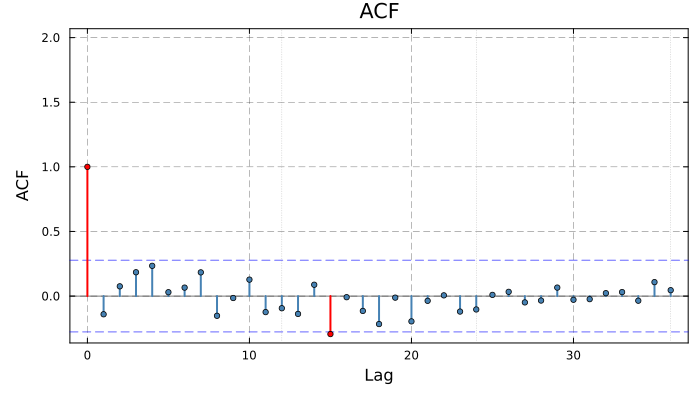

In [2]:
# Compute ACF
acf_result = acf(y, m)

# Inspect the result
acf_result           # prints summary
acf_result.values    # ACF values at each lag (including lag 0 = 1.0)
acf_result.lags      # lag indices
acf_result.ci        # 95% confidence interval: ±1.96/√n

# Specify number of lags
acf_result = acf(y, m, 36)  # up to 36 lags

# Plot ACF
plot(acf_result)


**Interpretation:**

- Values outside the $\pm 1.96/\sqrt{n}$ bands (dashed lines) are statistically significant at the 5% level.
- Slow decay in ACF suggests non-stationarity (need differencing).
- Seasonal spikes at lags $m, 2m, 3m, \ldots$ indicate seasonal patterns.
- ACF that cuts off after lag $q$ suggests an MA($q$) process.

### PACF — Partial Autocorrelation Function

The PACF measures the correlation between $y_t$ and $y_{t-k}$ after removing the effect of intermediate lags. Computed using the Durbin-Levinson algorithm.

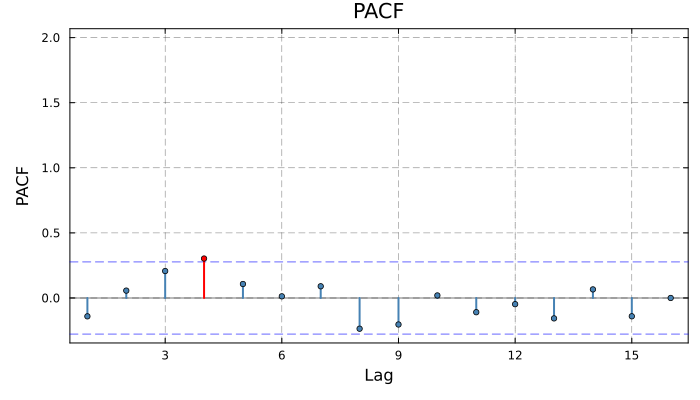

In [3]:
# Compute PACF
pacf_result = pacf(y, m)

pacf_result.values   # PACF values (lags 1, 2, ..., nlags)
pacf_result.lags     # lag indices (starts at 1, not 0)

# Plot PACF
plot(pacf_result)


**Interpretation:**

- PACF that cuts off after lag $p$ suggests an AR($p$) process.
- Significant spikes at seasonal lags ($m, 2m, \ldots$) suggest seasonal AR terms.

> 💡 **Tip**: ACF/PACF Decision Rules for ARIMA
>
>
> | Pattern | ACF | PACF | Suggested Model |
> |---------|-----|------|-----------------|
> | AR($p$) | Exponential/oscillatory decay | Cuts off after lag $p$ | $p$ AR terms |
> | MA($q$) | Cuts off after lag $q$ | Exponential/oscillatory decay | $q$ MA terms |
> | ARMA($p,q$) | Decays after lag $q$ | Decays after lag $p$ | Both AR and MA |
>
> For seasonal patterns, examine lags at multiples of $m$.


## Box-Cox Transformation

The Box-Cox transformation stabilises variance across time, which is a common assumption for many forecasting models. The family is defined as:

$$
w_t = \begin{cases}
\log(y_t) & \text{if } \lambda = 0 \\
\frac{\text{sign}(y_t)|y_t|^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0
\end{cases}
$$

### Automatic Lambda Selection

Durbyn provides two methods for choosing $\lambda$:

1. **Guerrero's method** Guerrero (1993): minimises the coefficient of variation of subseries (default)
2. **Profile log-likelihood**: maximises the log-likelihood of a fitted linear model

In [4]:
# Automatic lambda selection
lambda = box_cox_lambda(y, m)
println("Optimal λ = $lambda")

# Guerrero's method (default)
lambda_guer = box_cox_lambda(y, m, method="guerrero")

# Log-likelihood method
lambda_loglik = box_cox_lambda(y, m, method="loglik")

println("Guerrero: λ = $lambda_guer")
println("LogLik:   λ = $lambda_loglik")

Optimal λ = -0.7053543105886625
Guerrero: λ = -0.7053543105886625
LogLik:   λ = 0.3



### Applying and Inverting the Transformation

In [5]:
# Transform
y_bc, lambda = box_cox(y, m)  # auto lambda
y_bc2, _ = box_cox(y, m, lambda=0.0)  # force log transform
y_bc3, _ = box_cox(y, m, lambda=0.5)  # square root transform

# Inverse transform
y_original = inv_box_cox(y_bc, lambda=lambda)

# Bias-adjusted inverse (for forecasts)
# When back-transforming forecasts, median ≠ mean
# biasadj=true corrects for this
y_adj = inv_box_cox(y_bc, lambda=lambda, biasadj=true, fvar=0.01)

50-element Vector{Float64}:
      1.5136753250930216e6
      1.5136753250930216e6
 933655.8831314968
      4.632087875389967e6
      2.7058309053677605e6
      1.2032504235023137e6
      3.195091022914468e6
 703160.6995578782
      4.632087875389967e6
      5.647203558836933e6
      ⋮
      1.0634550229874444e6
 285490.5185026711
 933655.8831314968
      6.390147148696658e6
      2.0594147810228919e6
      2.2634566881962237e6
      1.0420776053476553e7
      1.5136753250930216e6
      1.2032504235023137e6

> 📝 **Note**: Common Lambda Values
>
>
> | $\lambda$ | Transformation |
> |-----------|----------------|
> | $-1$ | Inverse |
> | $-0.5$ | Inverse square root |
> | $0$ | Natural log |
> | $0.5$ | Square root |
> | $1$ | Identity (no transformation) |
> | $2$ | Square |
>
> In practice, $\lambda$ near 0 (log) is most common for economic and financial time series.


## Classical Decomposition

Decomposition separates a time series into three components:

$$
y_t = \begin{cases}
T_t + S_t + R_t & \text{(additive)} \\
T_t \times S_t \times R_t & \text{(multiplicative)}
\end{cases}
$$

where $T_t$ is the trend-cycle, $S_t$ is the seasonal component, and $R_t$ is the remainder.

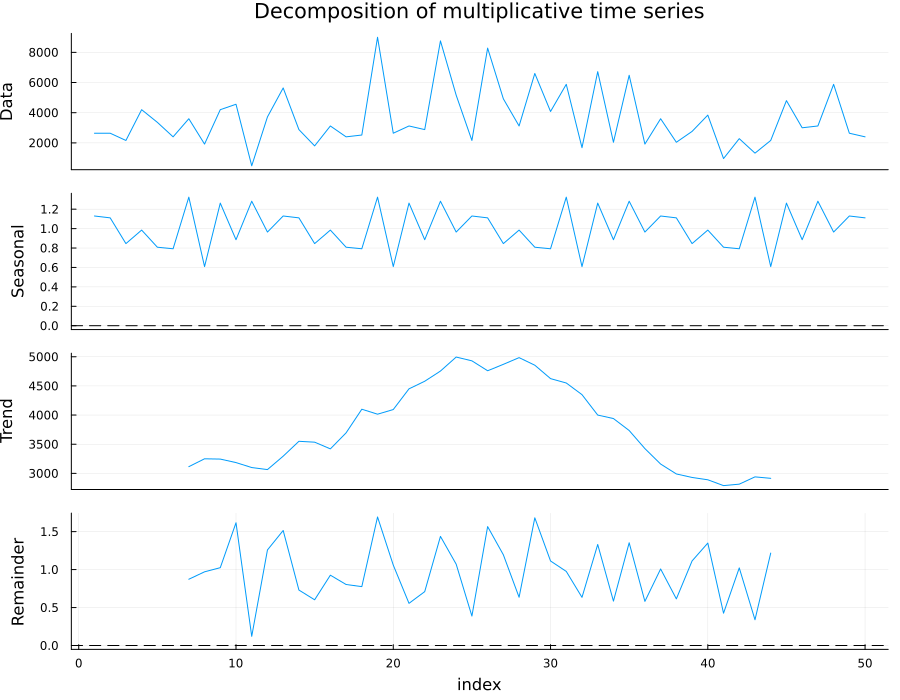

In [6]:
# Additive decomposition
dec_add = decompose(x=y, m=12, type="additive")

# Multiplicative decomposition
dec_mul = decompose(x=y, m=12, type="multiplicative")

# Access components
dec_add.trend      # trend-cycle component
dec_add.seasonal   # seasonal component
dec_add.random     # remainder (random) component
dec_add.figure     # seasonal figure (one period)
dec_add.type       # "additive" or "multiplicative"
dec_add.m          # frequency

# Plot (requires Plots.jl)
plot(dec_mul)

> ❗ **Important**: Additive vs Multiplicative
>
>
> - **Additive**: seasonal fluctuations are roughly constant in magnitude regardless of the level. Use when the seasonal pattern does not grow with the level.
> - **Multiplicative**: seasonal fluctuations are proportional to the level. Use when the data shows increasing seasonal variation over time (common in economic data).
>
> If unsure, apply a log transformation ($\lambda = 0$) to make it additive, then use additive decomposition.


## STL Decomposition

STL (Seasonal and Trend decomposition using Loess) Cleveland et al. (1990) is a more robust and flexible alternative to classical decomposition. It handles:

- Any frequency
- Non-linear trends
- Changing seasonal patterns
- Outlier robustness

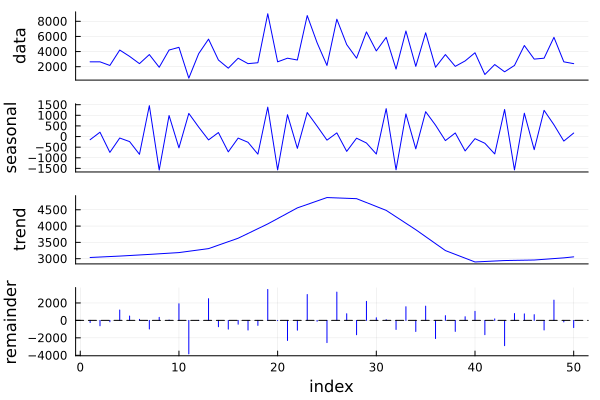

In [7]:
import Durbyn; plot
# STL decomposition
stl_result = stl(y, m, s_window = 12)

# Access components
stl_result.time_series.seasonal    # seasonal component
stl_result.time_series.trend       # trend component
stl_result.time_series.remainder   # remainder

# Robustness weights (downweight outliers)
stl_result.weights

# Smoothing parameters used
stl_result.windows    # (s=..., t=..., l=...)
stl_result.degrees    # polynomial degrees
stl_result.inner      # number of inner iterations
stl_result.outer      # number of outer (robustness) iterations

# Plot
plot(stl_result)


### MSTL — Multiple Seasonal Decomposition

For data with multiple seasonal periods (e.g., hourly data with daily and weekly cycles):

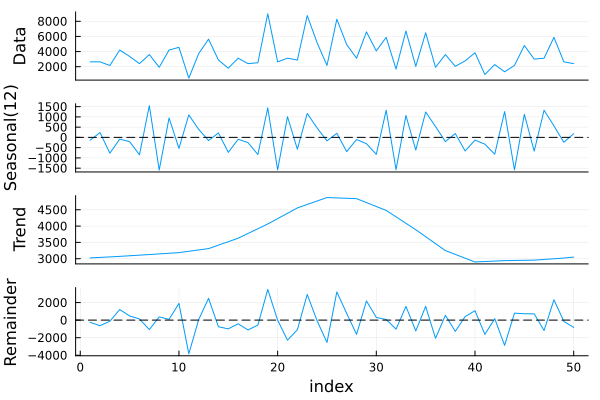

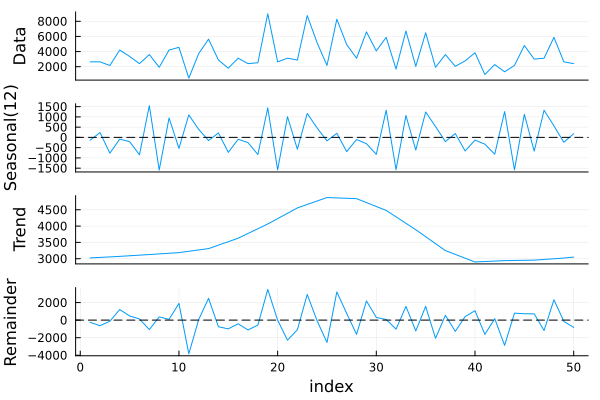

In [10]:
# MSTL decomposition
mstl_result = mstl(y, m)

plot(mstl_result)



### Seasonal Strength

Quantify the strength of seasonality on a 0–1 scale Hyndman & Athanasopoulos (2021):

$$
F_S = \max\left(0,\; 1 - \frac{\text{Var}(R_t)}{\text{Var}(S_t + R_t)}\right)
$$

In [11]:
strength = seasonal_strength(y, m)
println("Seasonal strength: $strength")
# Values near 1 indicate strong seasonality
# Values near 0 indicate weak/no seasonality

Seasonal strength: [0.22758468887332306]



## Stationarity Testing

A time series is **stationary** if its statistical properties (mean, variance, autocorrelation) do not change over time. Most forecasting models require stationarity (achieved through differencing).

### ADF — Augmented Dickey-Fuller Test

Tests $H_0$: the series has a unit root (non-stationary) vs $H_1$: stationary.

In [12]:
# ADF test
adf_result = adf(y)

adf_result          # prints summary with test statistic and critical values

ADF (Augmented Dickey–Fuller) Unit Root Test
Deterministic component (model): none
Lag truncation (bandwidth): 1

Test statistic(s):
           tau1                
statistic  -1.339847203526577  


Critical values:
  level     1%     5%    10%
   tau1  -2.62  -1.95  -1.61

Regression fields available in `x.testreg` (not shown).



**Decision**: Reject $H_0$ (conclude stationary) if the test statistic is more negative than the critical value at your chosen significance level.

### KPSS Test

Tests $H_0$: the series is stationary vs $H_1$: has a unit root.

In [13]:
# KPSS test
kpss_result = kpss(y)

kpss_result         # prints summary

KPSS Unit Root / Cointegration Test
Deterministic component (type): level (mu)
Lag truncation (bandwidth): 3

The value of the test statistic is: 0.204

Critical values:
   10% : 0.347
    5% : 0.463
    2% : 0.574
    1% : 0.739



**Decision**: Reject $H_0$ (conclude non-stationary) if the test statistic exceeds the critical value.

> 📝 **Note**: ADF vs KPSS
>
>
> The ADF and KPSS tests have *opposite* null hypotheses. It is good practice to use both:
>
> | ADF Result | KPSS Result | Conclusion |
> |------------|-------------|------------|
> | Reject $H_0$ | Fail to reject $H_0$ | Stationary |
> | Fail to reject $H_0$ | Reject $H_0$ | Non-stationary |
> | Both reject | Conflicting — more investigation needed |
> | Neither rejects | Borderline — may need more data |


### Phillips-Perron Test

An alternative unit root test that is more robust to serial correlation and heteroskedasticity:

In [14]:
pp_result = phillips_perron(y)
pp_result

Phillips-Perron Unit Root Test
Deterministic component (model): constant (intercept only)
Test type: Z-alpha
Lag truncation (lmax): 3

The value of the test statistic is: -60.7386

Auxiliary statistics:
  Z-tau-mu  : 6.9095

Critical values:
    1% : NaN
    5% : NaN
   10% : NaN



### Automatic Differencing: `ndiffs` and `nsdiffs`

Instead of manually running tests, use the automatic order-selection functions:

In [15]:
# Number of regular differences needed for stationarity
d = ndiffs(y)
println("Regular differences needed: $d")

# Number of seasonal differences needed
D = nsdiffs(y, m)
println("Seasonal differences needed: $D")

Regular differences needed: 0
Seasonal differences needed: 0



## Differencing

Differencing is the primary tool for achieving stationarity.

### Regular Differencing

The first difference removes a linear trend:

$$
\nabla y_t = y_t - y_{t-1}
$$

In [23]:
# First difference
y_diff1 = Durbyn.Stats.diff(y)

# Second difference (removes quadratic trend)
y_diff2 = Durbyn.Stats.diff(y, differences=2)

# Custom lag
y_diff_lag2 = Durbyn.Stats.diff(y, lag=2)

50-element Vector{Float64}:
   NaN
   NaN
  -480.0
  1560.0
  1200.0
 -1800.0
   240.0
  -480.0
   600.0
  2640.0
     ⋮
 -1560.0
   360.0
  -120.0
  3480.0
   840.0
 -1680.0
  2880.0
  -480.0
 -3480.0


### Seasonal Differencing

Seasonal differencing removes the seasonal pattern:

$$
\nabla_m y_t = y_t - y_{t-m}
$$

In [25]:
# Seasonal difference (lag = m)
y_sdiff = Durbyn.Stats.diff(y, lag=m)

# Combined: seasonal then first difference
y_both = Durbyn.Stats.diff(Durbyn.Stats.diff(y, lag=m))

50-element Vector{Float64}:
   NaN
   NaN
   NaN
   NaN
   NaN
   NaN
   NaN
   NaN
   NaN
   NaN
     ⋮
  3840.0
 -2760.0
  5040.0
 -2400.0
  2880.0
 -4320.0
  7320.0
 -4920.0
  1320.0

> 💡 **Tip**: Differencing Strategy
>
>
> 1. Check `nsdiffs(y, m)` — apply seasonal differencing first if $D = 1$
> 2. Check `ndiffs(y_seasonally_differenced)` — then apply regular differencing
> 3. Verify with ACF: a stationary series has ACF values that decay quickly to zero


## Fourier Terms

Fourier terms provide an alternative to seasonal dummy variables for modelling seasonal patterns, particularly useful when $m$ is large or non-integer.

$$
x_{k,t}^{(s)} = \sin\left(\frac{2\pi k t}{m}\right), \qquad
x_{k,t}^{(c)} = \cos\left(\frac{2\pi k t}{m}\right)
$$

In [26]:
# Generate Fourier terms for K harmonics
K = 6  # number of harmonics (max = m/2)
fourier_terms = fourier(y, m=m, K=K)

# For forecasting h steps ahead
fourier_future = fourier(y, m=m, K=K, h=12)

12×12 Matrix{Float64}:
  1.0          -7.35407e-16  -1.47081e-15  -1.0  …   3.42839e-15  0.0  -1.0
  0.866025     -0.5          -0.866025     -0.5     -0.5          0.0   1.0
  0.5          -0.866025     -0.866025      0.5      0.866025     0.0  -1.0
  1.10218e-15  -1.0          -2.20436e-15   1.0     -1.0          0.0   1.0
 -0.5          -0.866025      0.866025      0.5      0.866025     0.0  -1.0
 -0.866025     -0.5           0.866025     -0.5  …  -0.5          0.0   1.0
 -1.0          -2.93977e-15   5.87954e-15  -1.0     -4.88002e-16  0.0  -1.0
 -0.866025      0.5          -0.866025     -0.5      0.5          0.0   1.0
 -0.5           0.866025     -0.866025      0.5     -0.866025     0.0  -1.0
 -1.22465e-15   1.0          -2.44929e-15   1.0      1.0          0.0   1.0
  0.5           0.866025      0.866025      0.5  …  -0.866025     0.0  -1.0
  0.866025      0.5           0.866025     -0.5      0.5          0.0   1.0


## Missing Value Handling

Durbyn provides three strategies for handling missing values (`NaN`) in time series:

### `na_contiguous` — Longest Contiguous Block

Returns the longest contiguous run of non-missing values:

In [32]:
y_with_na = [NaN, 1.0, 2.0, NaN, 4.0, 5.0, 6.0, 7.0, NaN]

y_clean = na_contiguous(y_with_na)
# [4.0, 5.0, 6.0, 7.0]

4-element Vector{Float64}:
 4.0
 5.0
 6.0
 7.0


### `na_interp` — Interpolation

Replaces internal missing values using interpolation:

In [38]:
y_interp = na_interp(y_with_na, m = 12)

9-element Vector{Float64}:
 1.0
 1.0
 2.0
 3.0
 4.0
 5.0
 6.0
 7.0
 7.0


### `na_fail` — Strict Check

Throws an error if any missing values are found:

In [39]:
try
    na_fail(y_with_na)
catch e
    println("Error: ", e)
end

Error: ArgumentError("missing values in object")



### `na_action` — Dispatch by Name

In [41]:
# Use a strategy by name
y_clean = na_action(y_with_na, "na_contiguous")
y_clean = na_action(y_with_na, "na_interp")
# y_clean = na_action(y_with_na, "na_fail")

9-element Vector{Float64}:
 1.0
 1.0
 2.0
 3.0
 4.0
 5.0
 6.0
 7.0
 7.0

## References

#### Box-Cox Transformation

- Box, G.E.P., & Cox, D.R. (1964). An analysis of transformations. JRSS Series B, 26, 211-246.
- Guerrero, V.M. (1993). Time-series analysis supported by power transformations. Journal of Forecasting, 12, 37-48.

#### Unit Root Tests (ADF, KPSS, PP)

- Dickey, D.A., & Fuller, W.A. (1979). Distribution of the Estimators for Autoregressive Time Series with a Unit Root. JASA, 75, 427-431.
- Dickey, D.A., & Fuller, W.A. (1981). ADF test critical values.
- Kwiatkowski, D., Phillips, P.C.B., Schmidt, P., & Shin, Y. (1992). Testing the Null Hypothesis of Stationarity Against the Alternative of a Unit Root. Journal of Econometrics, 54, 159-178.
- Phillips, P.C.B., & Perron, P. (1988). Testing for a unit root in time series regression. Biometrika, 75(2), 335-346.
- MacKinnon, J.G. (1991). Critical Values for Cointegration Tests. In Engle & Granger (eds.), Oxford.
- Said, S.E., & Dickey, D.A. (1984). Testing for Unit Roots in ARMA Models of Unknown Order. Biometrika, 71, 599-607.

#### Seasonal Differencing (OCSB Test)

- Osborn, D.R., Chui, A.P.L., Smith, J., & Birchenhall, C.R. (1988). Seasonality and the order of integration for consumption. Oxford Bulletin of Economics and Statistics, 50(4), 361-377.
- Wang, X., Smith, K.A., & Hyndman, R.J. (2006). Characteristic-based clustering for time series data. Data Mining and Knowledge Discovery, 13(3), 335-364.
- Osborn, D.R. (1990). A survey of seasonality in UK macroeconomic variables. IJF, 6, 327-336.

#### Datasets

- Campbell, M.J., & Walker, A.M. (1977). Mackenzie River lynx data. JRSS Series A, 140, 411-431.
- Andrews, D.F., & Herzberg, A.M. (1985). Data: A Collection of Problems from Many Fields. Springer.

#### General Forecasting

- Hyndman, R.J., & Athanasopoulos, G. (2021). Forecasting: Principles and Practice (3rd ed.). OTexts.